# Object Detection Pipeline Documentation

This document describes an object detection pipeline implemented in Python using the YOLOv8 model for inference. The pipeline is designed to perform object detection on images, generate combined predictions from multiple models, find overlapping boxes between different models, and identify areas of interest based on a specified overlap threshold.

## Installation

To install the necessary dependencies, you can use the following command:



In [1]:
# %pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 5.8 MB/s eta 0:00:00


# Setup 

In [6]:
import os
import cv2
import shutil
import warnings
import ultralytics
import numpy as np
import pandas as pd
from ultralytics import YOLO
from google.colab import drive
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Ignore all warnings
warnings.filterwarnings("ignore")


ultralytics.checks()

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/107.7 GB disk)


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Helper Function

The fucntions defined below help with predicting the results of the models


## Script Overview

The object detection pipeline script consists of several Python functions organized into a coherent workflow. Here's an overview of each function:

### 1. `get_predictions`

- **Purpose:** Perform object detection inference using a pretrained YOLOv8 model.
- **Parameters:** `pretrained_weight`, `test_image`, `output_dir`
- **Returns:** `classes`, `results`
- **Description:** This function loads a pretrained YOLOv8 model specified by the `pretrained_weight` parameter, performs object detection inference on the `test_image`, and saves the inference results to the `output_dir`. It returns a list of class names (`classes`) obtained from the model and a list of Results objects (`results`) containing inference results.

In [8]:
def get_predictions(pretrained_weight: str, test_image: str, output_dir: str) -> Tuple[List[str], List[str]]:
    """
    Perform object detection inference using a pretrained YOLOv8 model.

    Parameters:
    - pretrained_weight (str): Path to the pretrained YOLOv8 model weights file.
    - test_image (str): Path to the test image for inference.
    - output_dir (str): Directory path for saving inference results.

    Returns:
    - classes (List[str]): List of class names obtained from the trained model.
    - results (List[Results]): List of Results objects containing inference results.

    Performs object detection inference using a pretrained YOLOv8 model on the specified test image.
    The function returns a list of class names obtained from the model and a list of Results objects
    containing inference results.
    """
    # Load the pretrained YOLOv8 model
    model = YOLO(pretrained_weight)

    # Run inference on the test image
    results = model.predict(source=test_image, save=True, save_txt=True, project=output_dir)

    # Get class names from the model
    classes = model.names

    return classes, results


### 2. `generate_combined_predictions`

- **Purpose:** Generate combined predictions from multiple object detection models.
- **Parameters:** `test_image`
- **Returns:** `combined_df`
- **Description:** This function generates combined predictions from multiple object detection models specified in the `pretrained_weight_dict`. It performs inference on the input `test_image` using each model and generates predictions. The combined predictions are saved to CSV files and plotted with bounding boxes overlaid on the image. The function returns a DataFrame (`combined_df`) containing the combined predictions.


In [11]:
def get_detections(result, classes):
    """
    Extracts object detection results from YOLOv5 inference results.

    Parameters:
    - result (List[Results]): List of Results objects containing inference results.
    - classes (Dict[int, str]): Dictionary mapping class indices to class names.

    Returns:
    - detections (List[Dict[str, Union[Tuple[float, float, float, float], str, float]]]): List of dictionaries representing detections.

    This function extracts object detection results from YOLOv5 inference results
    and structures them into a list of dictionaries with the following keys:
    - 'bounding_box_xywh': Tuple of (x, y, w, h) representing bounding box coordinates in xywh format.
    - 'bounding_box_xywhn': Tuple of (x_center, y_center, w, h) representing bounding box coordinates in xywhn format.
    - 'bounding_box_xyxy': Tuple of (x_min, y_min, x_max, y_max) representing bounding box coordinates in xyxy format.
    - 'bounding_box_xyxyn': Tuple of (x_center, y_center, width_normalized, height_normalized) representing bounding box coordinates in xyxyn format.
    - 'label': Class label assigned to the detection.
    - 'confidence': Confidence score associated with the detection.
    """
    # Initialize an empty list to store detection results
    detections = []

    # Iterate over each result object
    for res in result:
        boxes = res.boxes  # Boxes object for bbox outputs

        # Extract information and structure it into the desired format
        for i in range(len(boxes)):
            detection = {
                'bounding_box_xywh': tuple(boxes.xywh[i].numpy()),
                'bounding_box_xywhn': tuple(boxes.xywhn[i].numpy()),
                'bounding_box_xyxy': tuple(boxes.xyxy[i].numpy()),
                'bounding_box_xyxyn': tuple(boxes.xyxyn[i].numpy()),
                'label': classes.get(int(boxes.cls.numpy()[i]), 'unknown'),
                'confidence': boxes.conf.numpy()[i]
            }
            detections.append(detection)

    return detections


In [14]:
def generate_label_colors(labels: List[str]):
    """
    Generates label colors for visualization purposes.

    Parameters:
    - labels (List[str]): List of unique labels.

    Returns:
    - label_colors (Dict[str, str]): Dictionary mapping labels to color codes.

    This function generates label colors for visualization purposes. It assigns
    a unique color to each label in the input list of labels. The colors are chosen
    from a predefined set of solid colors for high contrast.
    """
    # Define a set of solid colors for high contrast
    solid_colors = [
        '#33FF57',  # Green
        '#337AFF',  # Blue
        '#FF33E6',  # Pink
        '#FFE333',  # Yellow
        '#8B33FF',  # Purple
        '#FF8C33',  # Orange
        '#FF3355',  # Light Red
        '#33FF33',  # Light Green
        '#3333FF',  # Light Blue
        '#FF33FF',  # Light Pink
        '#FFFF33',  # Light Yellow
        '#AA33FF',  # Light Purple
        '#FFAA33',  # Light Orange
        '#993300',  # Dark Red
        '#006600',  # Dark Green
        '#000099',  # Dark Blue
        '#990099',  # Dark Purple
    ]


    # Assign colors to labels
    label_colors = {}
    for i, label in enumerate(labels):
        label_colors[label] = solid_colors[i % len(solid_colors)]  # Use modulo to cycle through colors
    return label_colors


In [15]:
def plot_bounding_box_prediction(image: np.ndarray, detections: List[dict], output_path: str):
    """
    Plot bounding box predictions on the input image and save the plot.

    Parameters:
    - image (np.ndarray): Input image as a NumPy array.
    - detections (List[dict]): List of dictionaries containing detection information.
      Each dictionary should have keys 'bounding_box_xywhn', 'label', and 'confidence'.
      'bounding_box_xywhn': Tuple of floats representing bounding box coordinates in (x_center, y_center, width, height, normalized) format.
      'label': String representing the class label of the object.
      'confidence': Float representing the confidence score of the detection.
    - output_path (str): File path for saving the plot.

    Displays the input image with bounding box predictions overlaid and saves the plot to the specified output path.

    Each bounding box is drawn as a rectangle with the label and confidence score displayed next to it.
    The color of the bounding box border corresponds to the label class.
    """
    # Create a figure and axes without border
    fig, ax = plt.subplots()
    # Adjust figure margins to fit the image without borders
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Display the image without border
    ax.imshow(image)
    # Turn off the axes
    ax.axis('off')

    # Extract unique labels from detections
    labels = set(detection['label'] for detection in detections)

    # Generate label colors dynamically
    if len(labels) == 1:
        # If there's only one label, assign a single color
        label_colors = {list(labels)[0]: '#33FFFF'}  # Cyan color
    else:
        # Otherwise, generate colors using a predefined color palette
        label_colors = generate_label_colors(labels)

    # Add bounding boxes and labels for each detection
    for detection in detections:
        # Extract information from the detection dictionary
        bbox = detection['bounding_box_xywhn']
        label = detection['label']
        confidence = detection['confidence']

        # Convert normalized coordinates to pixel coordinates
        bbox_pixel = (
            (bbox[0] - bbox[2] / 2) * image.shape[1],  # x_min
            (bbox[1] - bbox[3] / 2) * image.shape[0],  # y_min
            (bbox[0] + bbox[2] / 2) * image.shape[1],  # x_max
            (bbox[1] + bbox[3] / 2) * image.shape[0]   # y_max
        )

        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle((bbox_pixel[0], bbox_pixel[1]), bbox_pixel[2] - bbox_pixel[0],
                                  bbox_pixel[3] - bbox_pixel[1], linewidth=1, edgecolor=label_colors[label],
                                  facecolor='none')

        # Add the rectangle patch to the axes
        ax.add_patch(rect)

        # Calculate text placement for label and confidence
        text_x = bbox_pixel[0] + 5
        text_y = bbox_pixel[1] - 10

        # Add label and confidence text next to the bounding box
        ax.text(text_x, text_y, f'{label}: {confidence:.2f}', color=label_colors[label], fontsize=8, weight='bold')

    # Save the plot to the specified output path
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close()

In [28]:
def generate_combined_predictions(test_image) -> pd.DataFrame:
    """
    Generate combined predictions from multiple object detection models.

    Parameters:
    - test_image (str): Path to the test image for inference.
    - pretrained_weight_dict (dict): Dictionary containing model types as keys and pretrained weights as values.
    - output_dir (str): Directory path for saving output files.
    - image_name (str): Name of the image file.

    Returns:
    - combined_df (pd.DataFrame): DataFrame containing combined predictions from all models.

    Generates combined predictions from multiple object detection models specified in the `pretrained_weight_dict`.
    The function performs inference on the input test image using each model and generates predictions.
    The combined predictions are saved to CSV files and plotted with bounding boxes overlaid on the image.
    The function returns a DataFrame containing the combined predictions.
    """
    combined_df = pd.DataFrame()

    for model_type, pretrained_weight in pretrained_weight_dict.items():
        print(f"{model_type} Model Results")

        # Perform object detection inference
        label, prediction = get_predictions(pretrained_weight, test_image, f"{output_dir}/{model_type}")

        # Copy labels from the prediction directory
        shutil.copytree(f"{output_dir}/{model_type}/predict/labels", f"{output_dir}/{model_type}", dirs_exist_ok=True)
        shutil.rmtree(f"{output_dir}/{model_type}/predict")

        # Get detections from the prediction
        detections = get_detections(prediction, label)
        image = plt.imread(test_image)
        output_path = f"{output_dir}/{model_type}/predicted_{image_name}"
        plot_bounding_box_prediction(image, detections, output_path)

        # Create DataFrame with detections
        df = create_detections_df(detections, model_type)
        df['model'] = model_type
        combined_df = combined_df.append(df, ignore_index=True)
        df['box_coordinates'] = df.apply(combine_coordinates, axis=1)
        df = df.reset_index().rename(columns={'index': 'box_index'})[['box_index', 'box_coordinates', 'label', 'confidence']]
        df.to_csv(f"{output_dir}/{model_type}/predicted_info.csv")

    # Plot overlapping predictions of one and minus model
    combined_df = combined_df.reset_index().rename(columns={'index': 'box_index'})
    one_image = plt.imread(f"{output_dir}/one/predicted_{image_name}")
    output_path = f"{output_dir}/overlap/{image_name}"
    os.makedirs(f"{output_dir}/overlap/", exist_ok=True)
    print("Overlapping predictions of One and Minus Model")
    plot_bounding_box_prediction(one_image, detections, output_path)

    return combined_df

### 2. `generate_combined_predictions`

- **Purpose:** Generate combined predictions from multiple object detection models.
- **Parameters:** `test_image`
- **Returns:** `combined_df`
- **Description:** This function generates combined predictions from multiple object detection models specified in the `pretrained_weight_dict`. It performs inference on the input `test_image` using each model and generates predictions. The combined predictions are saved to CSV files and plotted with bounding boxes overlaid on the image. The function returns a DataFrame (`combined_df`) containing the combined predictions.

### 3. `find_one_minus_overlap`

- **Purpose:** Find overlapping bounding boxes from different models in the combined DataFrame.
- **Parameters:** `bounding_box_df`
- **Returns:** `merged_df`
- **Description:** This function iterates over each pair of bounding boxes from different models in the DataFrame. It calculates the Intersection over Union (IoU) between each pair and records the overlap percentage. It then constructs a new DataFrame (`merged_df`) containing information about the overlapping pairs.

### 4. `get_areas_of_interest`

- **Purpose:** Get areas of interest based on IoU threshold.
- **Parameters:** `overlap_df`, `iou_threshold`
- **Returns:** `filtered_df`
- **Description:** This function filters the DataFrame to select areas of interest based on the IoU threshold. It groups the DataFrame by 'box_index' and finds the index of the row with the maximum IoU in each group. It selects the rows with the maximum IoU values using the indices and filters the rows with IoU values below the specified threshold.

### 5. `plot_areas_of_interest`

- **Purpose:** Plot areas of interest on the image and save the plot.
- **Parameters:** `image`, `area_of_interest_df`, `output_path`
- **Returns:** `df`
- **Description:** This function converts the DataFrame rows to dictionaries and appends them to a list. It then plots the bounding box predictions on the input image using the list of dictionaries and saves the plot. Finally, it returns a DataFrame containing box indices and coordinates.

### 6. `combine_coordinates`

- **Purpose:** Combine bounding box coordinates into a dictionary containing different formats.
- **Parameters:** `row`
- **Returns:** `dict`
- **Description:** This function combines bounding box coordinates into a dictionary containing different formats. It is used to apply the function to each row of the DataFrame.

### 7. `create_detections_df`

- **Purpose:** Create a DataFrame from a list of detections.
- **Parameters:** `detections`, `model_type`
- **Returns:** `DataFrame`
- **Description:** This function creates a pandas DataFrame from a list of detections. It adds a column 'box_coordinates' containing bounding box coordinates in the 'xywhn' format. It also adds a column 'model' with the specified model type for all rows.

### 8. `calculate_iou`

- **Purpose:** Calculate the Intersection over Union (IoU) between two bounding boxes.
- **Parameters:** `box1`, `box2`
- **Returns:** `float`
- **Description:** This function calculates the IoU between two bounding boxes defined by their (x_min, y_min, x_max, y_max) coordinates.

### 9. `main`

- **Purpose:** Main function to execute the object detection pipeline.
- **Description:** This function orchestrates the entire object detection pipeline. It generates combined predictions, finds overlapping boxes, identifies areas of interest, plots areas of interest on the image, and saves the results to CSV files.


In [17]:
# Function to combine coordinates into one column
def combine_coordinates(row):
    """
    Combine bounding box coordinates into a dictionary containing different formats.

    Parameters:
    - row (pandas.Series): A row containing bounding box coordinates in different formats.

    Returns:
    - dict: A dictionary containing bounding box coordinates in different formats.
    """
    return {
        'xywh': row['bounding_box_xywh'],
        'xywhn': row['bounding_box_xywhn'],
        'xyxy': row['bounding_box_xyxy'],
        'xyxyn': row['bounding_box_xyxyn']
    }


In [18]:
def create_detections_df(detections, model_type):
    """
    Create a DataFrame from a list of detections.

    Parameters:
    - detections (list): List of detection dictionaries.
    - model_type (str): Type of the model used for detections.

    Returns:
    - pandas.DataFrame: DataFrame containing detections and model type.

    This function creates a pandas DataFrame from a list of detections. It adds a column 'box_coordinates'
    containing bounding box coordinates in the 'xywhn' format. It also adds a column 'model' with the specified
    model type for all rows.
    """
    df = pd.DataFrame(detections)

    # Apply the function to each row
    df['box_coordinates'] = df['bounding_box_xywhn']
    df['model'] = [model_type] * df.shape[0]

    return df


In [19]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Parameters:
    - box1 (tuple): Tuple containing (x_min, y_min, x_max, y_max) of the first bounding box.
    - box2 (tuple): Tuple containing (x_min, y_min, x_max, y_max) of the second bounding box.

    Returns:
    - float: Intersection over Union (IoU) between the two bounding boxes.

    This function calculates the IoU between two bounding boxes defined by their (x_min, y_min, x_max, y_max) coordinates.
    """

    # Unpack the coordinates of the first bounding box
    x1_box1, y1_box1, x2_box1, y2_box1 = box1

    # Unpack the coordinates of the second bounding box
    x1_box2, y1_box2, x2_box2, y2_box2 = box2

    # Calculate the intersection area between the two bounding boxes
    x_intersection = max(0, min(x2_box1, x2_box2) - max(x1_box1, x1_box2))
    y_intersection = max(0, min(y2_box1, y2_box2) - max(y1_box1, y1_box2))
    intersection_area = x_intersection * y_intersection

    # Calculate the area of each bounding box
    area_box1 = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    area_box2 = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)

    # Calculate the union area of the two bounding boxes
    union_area = area_box1 + area_box2 - intersection_area

    # Calculate the IoU score
    if union_area > 0:
        iou = intersection_area / union_area
    else:
        iou = 0

    return iou


In [20]:
def find_one_minus_overlap(bounding_box_df):
    """
    Find overlapping bounding boxes from different models in the combined DataFrame.

    Parameters:
    - bounding_box_df (DataFrame): DataFrame containing bounding box information.

    Returns:
    - DataFrame: DataFrame with overlap information added.

    This function iterates over each pair of bounding boxes from different models in the DataFrame.
    It calculates the IoU (Intersection over Union) between each pair and records the overlap percentage.
    It then constructs a new DataFrame containing information about the overlapping pairs.
    """

    overlapping_pairs = []

    # Iterate over each pair of bounding boxes from different models
    for i in range(len(bounding_box_df)):
        for j in range(len(bounding_box_df)):
            if i != j and bounding_box_df.iloc[i]['model'] != bounding_box_df.iloc[j]['model']:
                box1 = bounding_box_df.iloc[i]['bounding_box_xyxy']
                box2 = bounding_box_df.iloc[j]['bounding_box_xyxy']

                # Calculate IoU between the bounding boxes
                iou = calculate_iou(box1, box2)

                if iou > 0:
                    overlap_percentage = iou * 100
                    overlapping_pairs.append((i, j, iou, overlap_percentage))

    # Prepare data for creating the DataFrame
    overlap_data = {'BoxIndex1': [], 'BoxIndex2': [], 'IoU': [], 'OverlapPercentage': []}

    # Populate the overlap data dictionary
    for pair in overlapping_pairs:
        box1_index, box2_index, iou, overlap_percentage = pair
        overlap_data['BoxIndex1'].append(box1_index)
        overlap_data['BoxIndex2'].append(box2_index)
        overlap_data['IoU'].append(iou)
        overlap_data['OverlapPercentage'].append(overlap_percentage)

    # Ensure each column has the same length for DataFrame creation
    max_length = max(len(overlap_data[key]) for key in overlap_data)

    for key in overlap_data:
        overlap_data[key] += [None] * (max_length - len(overlap_data[key]))

    # Create DataFrame for overlap data
    overlap_df = pd.DataFrame(overlap_data)

    # Merge overlap data with the original bounding box DataFrame
    merged_df = pd.merge(bounding_box_df, overlap_df, left_on='box_index', right_on='BoxIndex1', how='left')

    # Drop unnecessary columns
    merged_df.drop(columns=['BoxIndex1', 'BoxIndex2'], inplace=True)

    return merged_df


In [21]:
def get_areas_of_interest(overlap_df, iou_threshold):
    """
    Get areas of interest based on IoU threshold.

    Parameters:
    - overlap_df (DataFrame): DataFrame containing overlap information.
    - iou_threshold (float): IoU threshold for filtering areas of interest.

    Returns:
    - DataFrame: DataFrame containing areas of interest based on the IoU threshold.

    This function filters the DataFrame to select areas of interest based on the IoU threshold.
    It first fills NaN values in the 'IoU' column with 0.0.
    Then, it groups the DataFrame by 'box_index' and finds the index of the row with the maximum IoU in each group.
    It selects the rows with the maximum IoU values using the indices.
    Finally, it filters the rows with IoU values below the specified threshold and sets labels and confidence values.
    """

    # Fill NaN values in the 'IoU' column with 0.0
    overlap_df['IoU'] = overlap_df['IoU'].fillna(0.0)

    # Group the DataFrame by 'box_index' and find the index of the row with the maximum IoU in each group
    max_iou = overlap_df.groupby('box_index')['IoU'].idxmax()

    # Select the rows with the maximum IoU values using the indices
    max_iou_df = overlap_df.loc[max_iou]

    # Filter rows with IoU below the threshold
    filtered_df = max_iou_df[max_iou_df['IoU'] <= iou_threshold]

    # Set labels and confidence values
    filtered_df.loc[:, 'label'] = 'box_index'
    filtered_df['confidence'] = filtered_df['box_index']

    return filtered_df


In [22]:
def plot_areas_of_interest(image, area_of_interest_df, output_path):
    """
    Plot areas of interest on the image and save the plot.

    Parameters:
    - image (numpy array): Input image.
    - area_of_interest_df (DataFrame): DataFrame containing areas of interest.
    - output_path (str): Output path to save the plot.

    Returns:
    - DataFrame: DataFrame containing box indices and coordinates.

    This function converts the DataFrame rows to dictionaries and appends them to a list.
    It then plots the bounding box predictions on the input image using the list of dictionaries and saves the plot.
    Finally, it returns a DataFrame containing box indices and coordinates.
    """

    # Initialize an empty list to store dictionaries
    list_of_dicts = []

    # Iterate over each row of the DataFrame
    for _, row in area_of_interest_df.iterrows():
        # Convert the row to a dictionary and append it to the list
        list_of_dicts.append(row.to_dict())

    # Print signals of interest
    print("Signals of Interest")

    # Plot bounding box predictions on the image and save the plot
    plot_bounding_box_prediction(image, list_of_dicts, output_path)

    # Extract relevant columns from the DataFrame
    df = area_of_interest_df[['box_index', 'box_coordinates']]

    return df


In [23]:
def main():
    # Generate combined predictions for all models
    combined_predictions = generate_combined_predictions(test_image)

    # Find overlapping boxes between One and Minus models
    overlap_detections = find_one_minus_overlap(combined_predictions)

    # Get areas of interest with an overlap threshold of 0.2
    areas_of_interest = get_areas_of_interest(overlap_detections, 0.2)

    # Read the test image
    image = plt.imread(test_image)

    # Plot areas of interest on the image and save it
    output_image_path = output_dir + f'/areas_of_interest_{image_name}'
    plot_areas_of_interest(image, areas_of_interest, output_path=output_image_path)

    # Save areas of interest data to a CSV file
    csv_filename = image_name.replace('jpg', 'csv')
    areas_of_interest.to_csv(output_dir + f'/areas_of_interest_{csv_filename}')


# Implementation

## Usage

To use the object detection pipeline, you need to specify the test image path, output directory, and pretrained weights for each model type. Then, execute the `main` function.

```python
if __name__ == "__main__":
    main()

In [24]:
# Define the test image path and the output directory
test_image = '/content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/test_data/20181205T040004-File-21_20Hz_png.rf.24abc00e0643f9b909c8e4705064585b.jpg'
output_dir = '/content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/results'

# Define pretrained weights for each model type
pretrained_weight_dict = {
    'one': '/content/gdrive/MyDrive/Data 590 - Data Science Capstone/Implementation/Development/ONE_best.pt',
    'minus': '/content/gdrive/MyDrive/Data 590 - Data Science Capstone/Implementation/Development/minus_best.pt'
}

# Extract the image name from the test image path
image_name = test_image.split('/')[-1]


one Model Results

image 1/1 /content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/test_data/20181205T040004-File-21_20Hz_png.rf.24abc00e0643f9b909c8e4705064585b.jpg: 320x640 4 sounds, 838.5ms
Speed: 13.1ms preprocess, 838.5ms inference, 23.4ms postprocess per image at shape (1, 3, 320, 640)
Results saved to /content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/results/one/predict
1 label saved to /content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/results/one/predict/labels


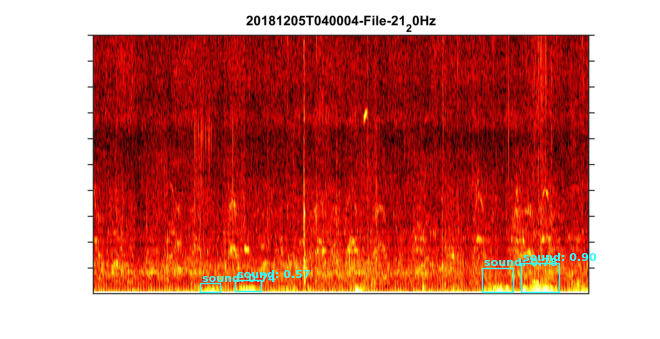

minus Model Results

image 1/1 /content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/test_data/20181205T040004-File-21_20Hz_png.rf.24abc00e0643f9b909c8e4705064585b.jpg: 320x640 3 flow noises, 710.6ms
Speed: 2.5ms preprocess, 710.6ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
Results saved to /content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/results/minus/predict
1 label saved to /content/gdrive/My Drive/Colab Notebooks/Capstone-Iterations/results/minus/predict/labels


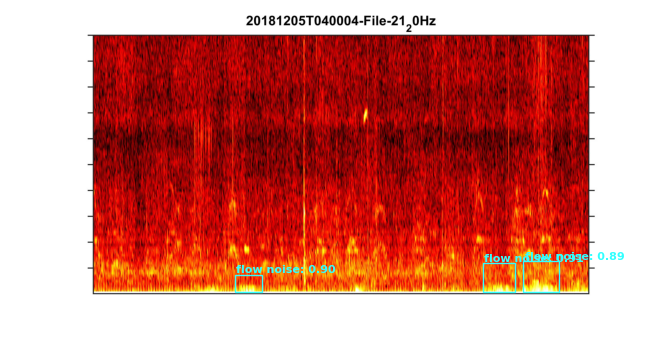

Overlapping predictions of One and Minus Model


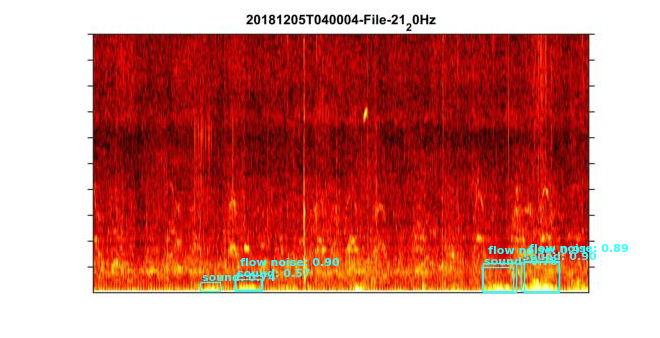

Signals of Interest


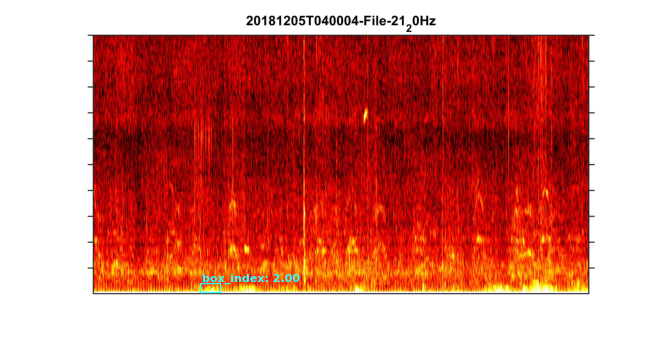

In [29]:

if __name__ == "__main__":
    main()
